# Self-Balancing Scooter Control

![](images/self-balancing-scooter.png)

> A self-balancing scooter [...] is a self-balancing personal transporter consisting of two motorized wheels connected to a pair of articulated pads on which the rider places their feet. The rider controls the speed by leaning forward or backward, and direction of travel by twisting the pads.
>
> Source: <https://en.wikipedia.org/wiki/Self-balancing_scooter>

### Python Dependencies

In [92]:
#useless comment
from numpy import *
from numpy.linalg import *

from scipy.linalg import *
from scipy.integrate import *
from scipy.signal import *

from matplotlib.pyplot import *

Step 1 - Scooter Planar Model
================================

### Introduction

We consider a simple model of a self-balancing scooter evolving in the plane. It is mainly made of

  - The frame that contains the two articulated pads; from above, each pad essentially look like a triangle (one vertice in the center of the frame, one vertice at each extremity of the wheel).

  - Two fixed wheels (their orientation with respect to the frame does not change).
    They are parallel and located at opposite ends of the frame.
    
Let $(0, e_x, e_y)$ be a direct orthonormal frame of the plane. We denote

  - $(x, y)$ the coordinates of the wheel axis center in the orthonormal and
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the scooter faces the right ($e_x$) and $\theta = \pi/2$ when it faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the scooter moves forward.

### Parameter Definition

From now on, we assume that the seat frame length is $\ell = 50 \mbox{ cm}$ and the wheel radius is $r = 12.5 \mbox{ cm}$.

🧩 Define the corresponding Python variables `l` and `r` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values.

In [93]:
# Define the seat frame length (l) in meters
l = 50 / 100  # converting cm to m

# Define the wheel radius (r) in meters
r = 12.5 / 100  # converting cm to m
# Define the seat frame length (l) in meters




### Graphical Representation

🧩 Implement a function `draw_scooter` with arguments `x`, `y` and `theta` that draws a simple geometric model of the wheelchair (with a red frame and black fixed wheels) in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. Use a green circle marker 50 cm in of the frame to indicate which way is forward.

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

In [94]:
def draw_scooter(x,y,theta):
  theta = theta - pi/2
  translation = array([[x], [y]])
  rotation = array([[cos(theta),-sin(theta)],
                   [sin(theta),cos(theta)]])
  t1 = array([[0, l/2, l/2, 0], [0, r, -r, 0]])
  t2 = array([[0, -l/2, -l/2, 0], [0, r, -r, 0]])
  fill(dot(rotation,t1)[0] + translation[0], dot(rotation,t1)[1] + translation[1], 'r', alpha=1)
  fill(dot(rotation,t2)[0] + translation[0], dot(rotation,t2)[1] + translation[1], 'r', alpha=1)
  r1 = array([[l/2, l/2], [r, -r]])
  plot(dot(rotation, r1)[0] + translation[0], dot(rotation, r1)[1] + translation[1], color='black', linestyle='-', linewidth=4)
  r2 = array([[-l/2, -l/2], [r, -r]])
  plot(dot(rotation, r2)[0] + translation[0], dot(rotation, r2)[1] + translation[1], color='black', linestyle='-', linewidth=4)
  scatter(dot(rotation, array([[0], [0.5]]))[0] + translation[0], dot(rotation, array([[0], [0.5]]))[1] + translation[1], s=40, color='green')



🧩 Represent the wheelchair when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, \pi), (-2, 2, 3\pi/2)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [95]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    figure(figsize=figsize)
    axes = gca()
    axes.axis([xmin, xmax, ymin, ymax])
    axes.set_aspect(1)
    xticks(arange(xmin, xmax+1, 1))
    yticks(arange(ymin, ymax+1, 1))
    grid(True)

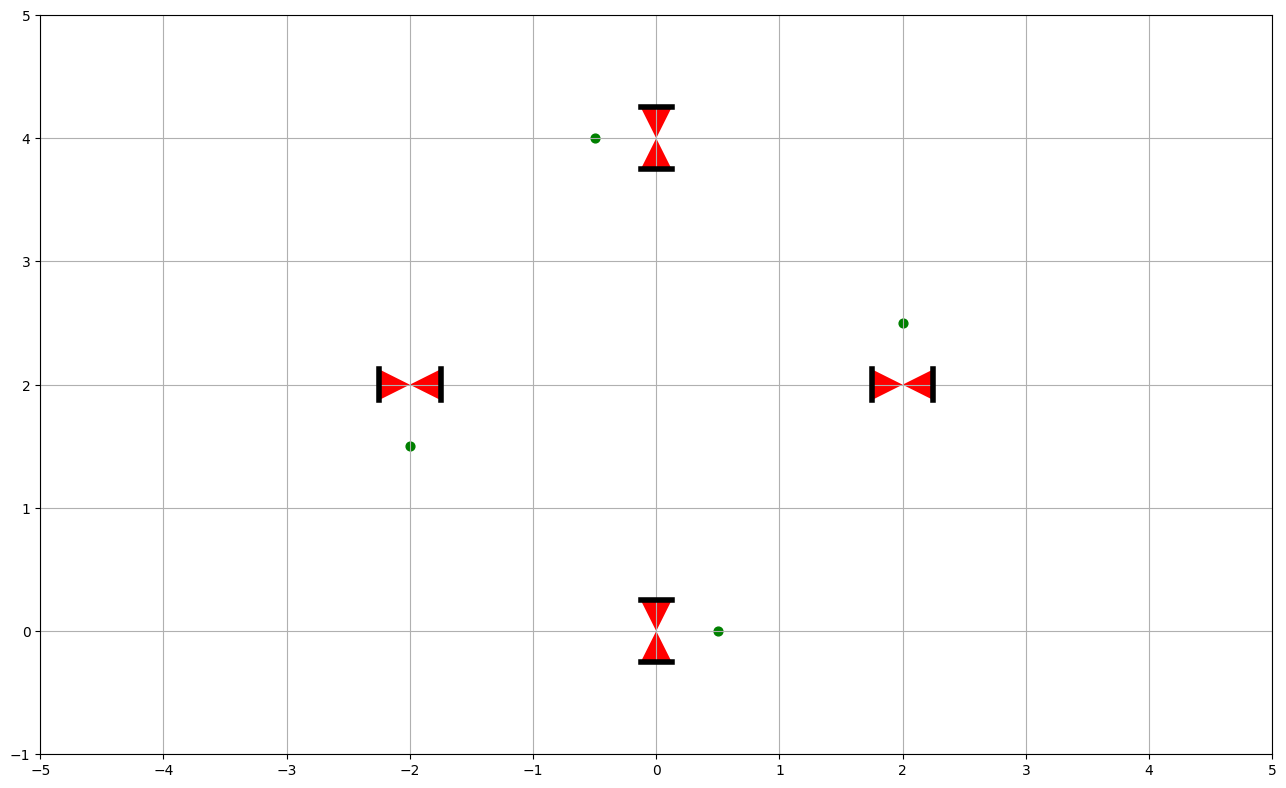

In [96]:
draw_arena(-5, 5, -1, 5)
draw_scooter(0, 0, 0)
draw_scooter(2, 2, pi/2)
draw_scooter(0, 4, pi)
draw_scooter(-2, 2, 3*pi/2)

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the wheelchair).
We also assume that the wheelchair fixed wheels roll without slipping.

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

The velocities of the left and right wheels can be expressed as `v_l = R * ωl` and `v_r = R * ωr` .

The linear velocity `v` of the scooter (which is also the velocity of the center of the wheel axis) can be obtained by averaging the velocities of the two wheels:

$$ v = \frac{v_l + v_r}{2} = \frac{R * ωl + R * ωr}{2} = R * \frac{ωl + ωr}{2} $$

The angular velocity `ω` of the scooter (rate of change of the direction of the scooter) can be obtained by the difference in velocities of the two wheels divided by the distance between the wheels:

$$ ω = \frac{v_r - v_l}{L} = \frac{R * ωr - R * ωl}{L} = R * \frac{ωr - ωl}{L} $$

The direction `θ` of the scooter changes at a rate equal to the angular velocity `ω`, so we have:

$$ θ˙ = ω $$

The velocity of the scooter in the x and y directions (`x˙` and `y˙`) can be obtained by decomposing the linear velocity `v` along the `ex` and `ey` directions:

$$ x˙ = v * cos(θ) = R * \frac{ωl + ωr}{2} * cos(θ) $$

$$ y˙ = v * sin(θ) = R * \frac{ωl + ωr}{2} * sin(θ) $$

So, the differential equations that relate `x˙`, `y˙` and `θ˙` with `ωl` and `ωr` are:

$$ x˙ = R * \frac{ωl + ωr}{2} * cos(θ) $$

$$ y˙ = R * \frac{ωl + ωr}{2} * sin(θ) $$

$$ θ˙ = R * \frac{ωr - ωl}{L} $$


### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

Since the vector field is continuously differentiable due to being a composition of continuously differentiable functions, the initial value problem is well-posed.

🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

**Constant Wheel Speeds**

When the speeds of the scooter's wheels, $\omega_l$ and $\omega_r$, remain constant, the equations governing its motion become linear concerning trigonometric functions of $\theta$. These equations have constant coefficients:

$\dot{x} = R \frac{\omega_l + \omega_r}{2} \cos(\theta)$

$\dot{y} = R \frac{\omega_l + \omega_r}{2} \sin(\theta)$

$\dot{\theta} = \frac{R (\omega_r - \omega_l)}{w}$

In this case:
- The terms controlling motion are limited as they include fixed coefficients and trigonometric functions.
- Nonlinear elements or dependencies, which could lead to unpredictable behavior or singularities, are absent.
- Consequently, the solutions are **universal**, extending across all time points ($ t \in (-\infty, \infty) $).

**Variable Wheel Speeds**

When $\omega_l$ and $\omega_r$ become functions of $x, y,$ and $\theta$ and are smoothly changeable:
- The system becomes nonlinear, potentially introducing intricate behaviors.
- The varying nature of $\omega_l(x, y, \theta)$ and $\omega_r(x, y, \theta)$ might lead to situations where the solution diverges or becomes undefined within a finite timeframe.
- Without further conditions ensuring the boundedness and absence of singularities in $\omega_l$ and $\omega_r$, **universal solutions cannot be guaranteed**.
For example with $\omega_r = - \omega_l = 0.5 (L/R_w)  \theta^2$, we end up with $\dot{\theta}(t) = \theta(t)^2$ which has a finite-time blowup for some initial values of $\theta$. 

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [97]:
def omega(t, xytheta):
    omega_l = (1 - l/4) * pi / r
    omega_r = (1 + l/4) * pi / r
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$ and $(x,y,\theta)$ (and implicitly the inputs $\omega$ computed by the function `omega`).

In [98]:
def fun(t, xytheta):
    x, y, theta = xytheta
    omega_l, omega_r = omega(t, xytheta)
    dx = r * 0.5 * (omega_l + omega_r) * cos(theta)
    dy = r * 0.5 * (omega_l + omega_r) * sin(theta)
    dtheta = r * (omega_r - omega_l) / l
    return array([dx, dy, dtheta])

### Simulation Setup

🧩 Simulate the wheelchair dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = (1 - \ell/4)  \pi / r \mbox{ rad/s}$ and $\omega_r = (1 + \ell/4)  \pi / r \mbox{ rad/s}$.
(Compute the dense outputs.)
   

In [99]:
simulate = solve_ivp(fun=fun, t_span =(0.0, 4.0), y0=[0.0, 0.0, 0.0], dense_output=True)

🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

Text(0.5, 0, 'time')

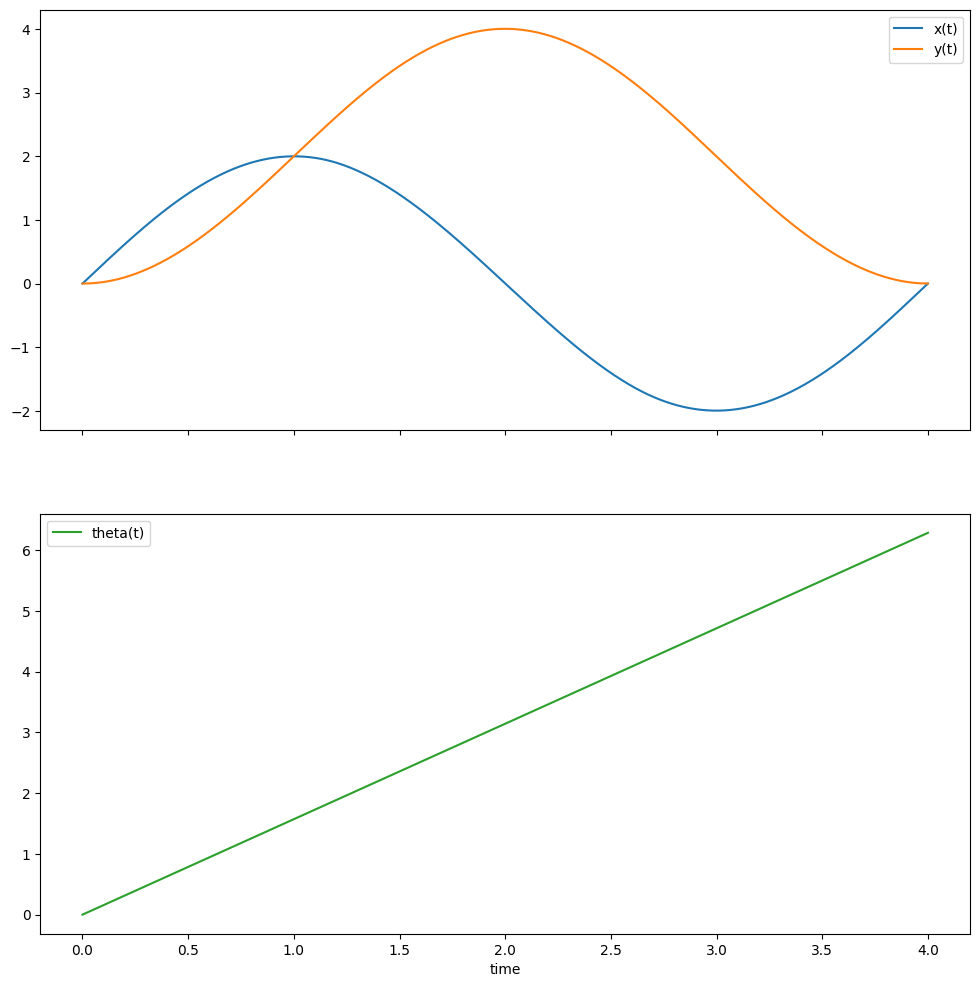

In [100]:
t = linspace(0.0, 4.0, 1000)
x, y, theta = simulate["sol"](t)
fig=figure(figsize=(12, 12))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.plot(t, x, label="x(t)")
ax1.plot(t, y, label="y(t)")
ax1.legend()
ax2.plot(t, theta, label=r"theta(t)", color="C2")
ax2.legend()
xlabel("time")

🧩 Use the simulation results to display the robot location every 0.5 second.

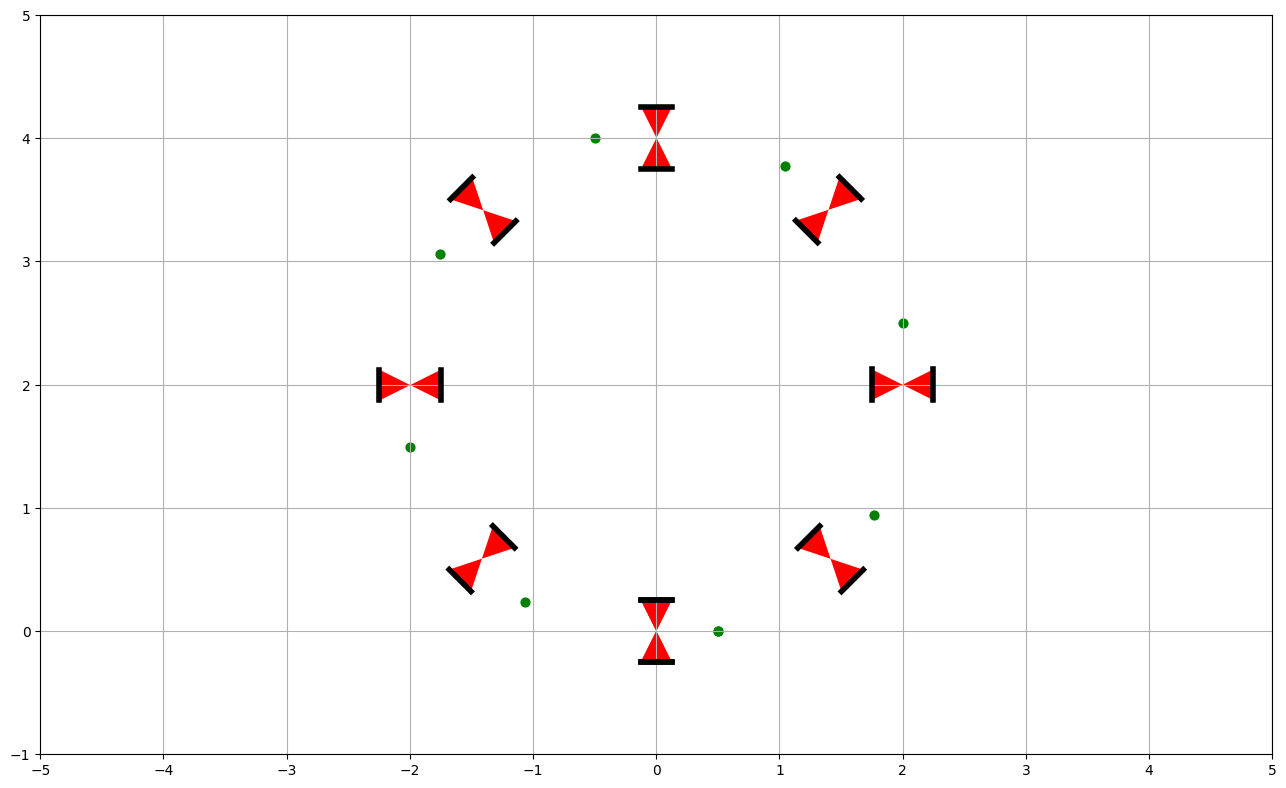

In [101]:
t = linspace(0.0, 4.0, 4*2+1)
sol_t = simulate["sol"](t)
draw_arena(-5, 5, -1, 5)
for x, y, theta in sol_t.T:
    draw_scooter(x, y, theta)

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$?

$\theta(t) = 2 \pi / 4.0$,
$x(t) = 2\sin(2\pi t / 4)$,
$y(t) = -2 \cos(2\pi t / 4)+2$

🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

Text(0.5, 0, 'time')

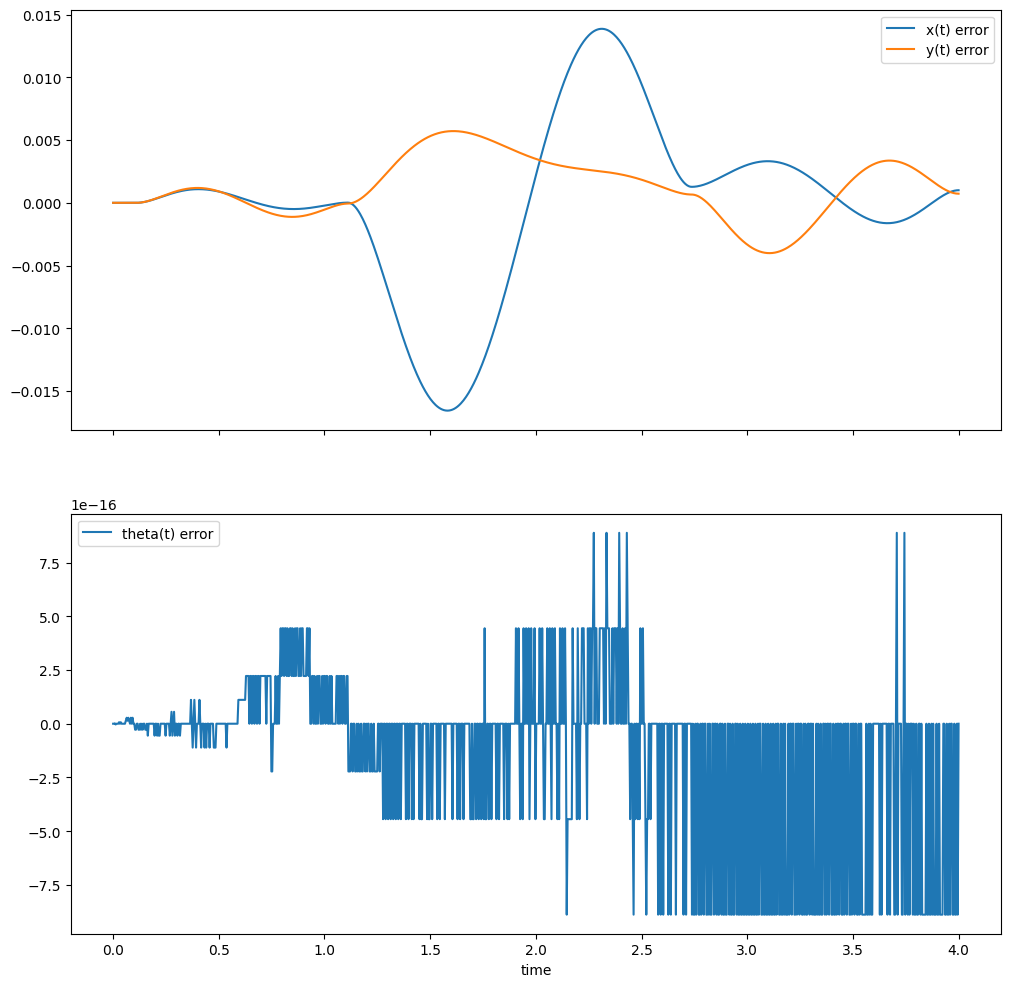

In [102]:
t = linspace(0.0, 4.0, 1000)
x_t, y_t, theta_t = simulate["sol"](t)
fig=figure(figsize=(12, 12))
ax1, ax2 = fig.subplots(2, 1, sharex=True)

ax1.plot(t , x_t - 2*sin(2*pi*t/4), label="x(t) error")
ax1.plot(t , y_t + 2*cos(2*pi*t/4) - 2, label="y(t) error")
ax1.legend()

ax2.plot(t, theta_t - 2*pi*t / 4.0, label=r"theta(t) error")
ax2.legend()
xlabel("time")


🧩 If needed, adjust the simulation parameters the simulated position error is less than $1\, \mathrm{ mm}$.

In [ ]:
simulate_1 = solve_ivp(
    fun=fun, 
    t_span=(0.0, 4.0), 
    y0=[0.0, 0.0, 0.0], 
    rtol=1e-6, 
    atol=1e-8, 
    dense_output=True
)
t = linspace(0.0, 4.0, 1000)
x_t, y_t, theta_t = simulate_1["sol"](t)
fig=figure(figsize=(12, 12))
ax1, ax2 = fig.subplots(2, 1, sharex=True)

ax1.plot(t , x_t - 2*sin(2*pi*t/4), label="x(t) error")
ax1.plot(t , y_t + 2*cos(2*pi*t/4) - 2, label="y(t) error")
ax1.legend()

ax2.plot(t, theta_t - 2*pi*t / 4.0, label="theta(t) error")
ax2.legend()
xlabel("time")
